In [89]:
import ot
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from gerrychain import Graph
from math import sqrt
from numpy.linalg import inv, matrix_power
from scipy.linalg import expm
from tqdm import tqdm

In [90]:
'''
given an an adjacency matrix for a graph G, produce the transition
matrix for the random walk on G
'''
def form_markov_chain(adj_mat):
    return inv(np.diag(np.sum(adj_mat, axis=1))) @ adj_mat
    

'''
given a valid cost matrix, return the indices which represent points
achieving the diameter of the set
'''

def max_dist(cost):
    return np.unravel_index(cost.argmax(), cost.shape)
'''
given a Markov chain p, produce the vector representing its steady state
'''
def find_steady_state(p):
    dim = p.shape[0]
    q = (p-np.eye(dim))
    ones = np.ones(dim)
    q = np.c_[q,ones]
    QTQ = np.dot(q, q.T)
    bQT = np.ones(dim)
    return np.linalg.solve(QTQ,bQT)

'''
given a Markov chain (or any power of it) mchain with steady state steady_state,
compute the diffusion distance between vertices i and j
'''
def diffusion_distance(mchain, steady_state, i, j):
    vec = ((mchain[i,:] - mchain[j,:]) ** 2 )/ steady_state

    return sqrt(np.sum(vec))

'''
given a Markov chain mchain and a time t, produce the matrix encoding the diffusion
distances between all pairs of nodes
'''
def form_diffusion_map(mchain, t):
    time_scaled_chain = matrix_power(mchain, t)
    steady_state = find_steady_state(mchain)
    dim = mchain.shape[0]
    D = np.zeros((dim,dim))
    for i in range(dim):
        for j in range(i + 1, dim):
            D[i,j] = diffusion_distance(time_scaled_chain, steady_state, i, j)
            D[j,i] = D[i,j]
    
    return D

'''
returns a random probability measure on a graph with num_nodes number of nodes
'''
def random_measure(num_nodes):
    unnormalized_measure = np.random.rand(num_nodes)
    return unnormalized_measure / np.linalg.norm(unnormalized_measure, 1)

'''
given a number of nodes n and a number of measures to be produced m
return a n x m matrix whose columns correspond to probability measures
on a set of n elements
'''
def generate_measures(n: int, m: int):
    arr = np.empty((n,m))
    for i in range(m):
        arr[:, i] = random_measure(n)
    return arr

'''
given two measures head, tail and an array of measures measures, concatenate tail to the end of measures and measures to head
'''
def concatenate_measures(endpts, measures):
    return np.c_[np.c_[endpts[:,0], measures], endpts[:,1]]

def uniform_measure(num_nodes):
    weight = 1 / num_nodes
    v = [weight] * num_nodes
    return np.array(v)

In [91]:
'''
measures == a matrix with columns corresponding to the reference measures
approximant == a matrix with columns corresponding to ... some tool in the step I don't grok
cost_mat == matrix encoding cost of moving mass i --> j
coords == a point in the |measures|-simplex
'''
def _sinkhorn_loop(measures, approximant, cost_mat, coords):
    s = measures.shape[1] # the number of columns is the number of reference measures
    v = cost_mat.shape[1] # measures are supported on v vertices and must be vectores of length v
    phi = np.empty(measures.shape) #

    for i in range(s):
        b = approximant[:, i] # get the i-th column of the approximant matrix
        p = measures[:, i]    # get the i-th column of the reference matrix
        phi[:,i] = cost_mat.T @ (p / (cost_mat @ b))

    p = np.ones(v)
    for i in range(s):
        p = p * (phi[:,i] ** coords[i])

    b = np.empty(measures.shape)
    for i in range(s):
        phi_col = phi[:,i]
        b[:, i] = np.divide(p, phi_col, out=np.zeros_like(p), where=phi_col!=0)

    return b, p

'''
measures == a matrix with columns corresponding to the reference measures
cost_mat == matrix encoding cost of moving mass i --> j
coords == a point in the |measures|-simplex
steps == number of iterations to carry out
'''

def _barycenter(measures, cost, coords, steps=3):
    ones = np.ones((cost.shape[0], measures.shape[1]))
    b, barycenter = barycentric_stepper(measures, ones, cost, coords)
    for _ in range(steps):
        b, barycenter = sinkhorn_loop(measures, b, cost, coords)
    return barycenter        
 

In [ ]:
graph = Graph.from_file('./IA_counties/IA_counties.shp')

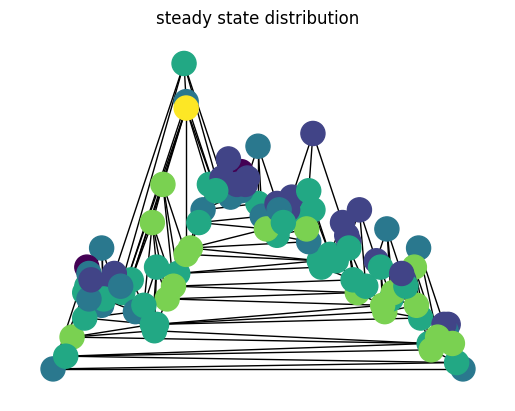

In [99]:
ia_markov = form_markov_chain(nx.adjacency_matrix(graph))
num_nodes = ia_markov.shape[0]
fig, ax = plt.subplots()
ax.set_title("steady state distribution")
nx.draw_planar(graph, node_color=steady_state)


In [105]:
i,j = max_dist(diffusion_cost)
i, j

(21, 43)

  0% 0/5 [00:00<?, ?it/s]

 20% 1/5 [00:22<01:31, 22.88s/it]

 40% 2/5 [00:46<01:10, 23.36s/it]

 60% 3/5 [01:08<00:45, 22.51s/it]

 80% 4/5 [01:28<00:21, 21.84s/it]

100% 5/5 [01:49<00:00, 21.42s/it]

100% 5/5 [01:49<00:00, 21.91s/it]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

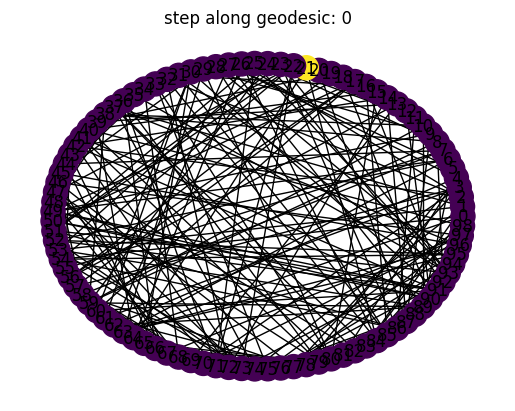

In [109]:
def update(frame):
    ax.clear()
    nx.draw_circular(graph, node_color = geodesic[:,frame], with_labels=True)
    ax.set_title(f"step along geodesic: {frame}")


def geodesic_path(measures, cost, steps=10, epsilon=0.1):
    barycenters = np.empty((measures.shape[0], steps))
    for i in range(steps):
        barycenters[:, i] = ot.barycenter(measures, cost, epsilon, weights=[1 - i/steps, i/steps])
    return concatenate_measures(measures, barycenters)
    
    
for time in tqdm(range(1,10,2)):
    diffusion_cost = form_diffusion_map(ia_markov, time)
    measures = np.zeros((num_nodes, 2))
    measures[i,0] = 1
    measures[j,1] = 1
    #measures = np.array([uniform_measure(num_nodes), find_steady_state(ia_markov)]).T
    geodesic = geodesic_path(measures, diffusion_cost, steps=50)
    plt.clf()
    fig, ax = plt.subplots()
    
    ani = animation.FuncAnimation(fig=fig, func=update, frames=steps+2, interval=100, repeat=True)
    ani.save(filename=f"./diracs/dirac-path-diffusion-scale-{time}.gif", writer="imagemagick")

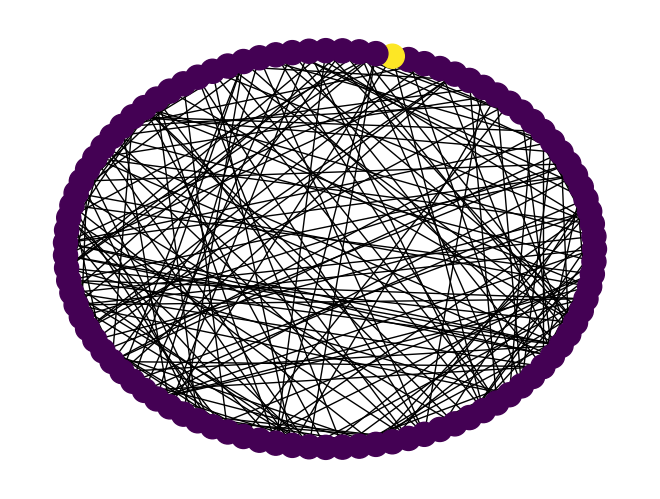

In [111]:
nx.draw_circular(graph, node_color=measures[:,0])

In [ ]:
node_count = pa_diff_cost.shape[0]
nu_0 = random_measure(node_count)
nu_1 = random_measure(node_count)

In [ ]:
pa_measures = np.empty((node_count, 2))
pa_measures[:,0] = nu_0
pa_measures[:,1] = nu_1

In [ ]:
geodesic_steps = 10
barycenters = np.empty((node_count,geodesic_steps))
for i in range(0, geodesic_steps):
    coordinates = np.array([i / geodesic_steps, 1 - i/geodesic_steps])
    barycenters[:,i] = barycenter(pa_measures, pa_diff_cost, coordinates, steps=10)
sns.heatmap(barycenters)

In [7]:
hand_made_adj_mat = np.array([
        [0,1,1,0,1],
        [1,0,0,0,1],
        [0,1,0,1,1],
        [0,0,1,0,1],
        [1,1,1,1,0]
       ]
)

mu_0 = random_measure(5)
mu_1 = random_measure(5)
measures=np.empty((5,2))
measures[:,0] = mu_0
measures[:,1] = mu_1

In [39]:
epsilon = 1
upsilon = 0.5
cost= form_diffusion_map(form_markov_chain(hand_made_adj_mat), 1)
barycenter_small = ot.barycenter(measures, cost, epsilon)
entropic_0_small = ot.barycenter(measures,cost, epsilon, weights=[1.0,0.0])
entropic_1_small = ot.barycenter(measures,cost, epsilon, weights=[0.0,1.0])
barycenter_very_small = ot.barycenter(measures, cost, upsilon)
entropic_0_very_small = ot.barycenter(measures,cost, upsilon, weights=[1.0,0.0])
entropic_1_very_small = ot.barycenter(measures,cost, upsilon, weights=[0.0,1.0])
print(mu_0)
print(entropic_0_small)
print(entropic_0_very_small)
print(mu_0 - entropic_0_very_small)
#print(mu_1)
#print(entropic_1_small)
#print(entropic_1_very_small)


[0.2031319  0.02612742 0.19902379 0.19573395 0.37598294]
[0.23359702 0.12124351 0.17508781 0.2220869  0.24798476]
[0.23251459 0.06860787 0.16510649 0.21842182 0.31534923]
[-0.02938269 -0.04248045  0.0339173  -0.02268787  0.06063371]


<Axes: >

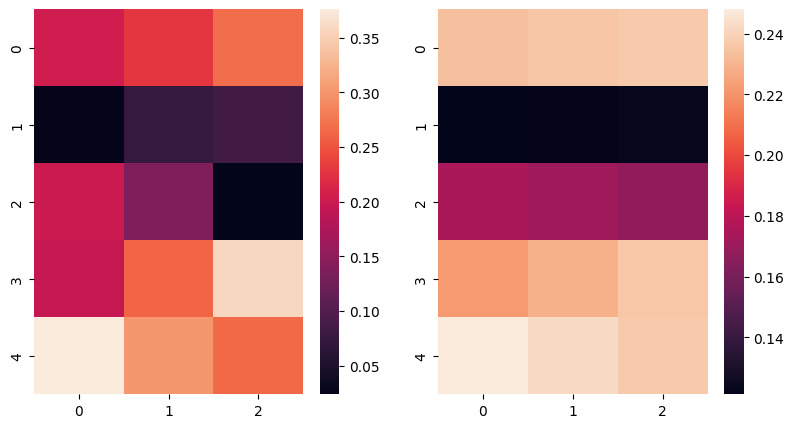

In [34]:
transition_0 = np.c_[np.c_[entropic_0_small, barycenter_small], entropic_1_small]
transition_1 = np.c_[np.c_[entropic_0_very_small, barycenter_very_small], entropic_1_very_small]
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
sns.heatmap(data=transition_0, ax=ax1)
sns.heatmap(data=transition_1, ax=ax2)


In [ ]:
markov_chain = form_markov_chain(hand_made_adj_mat)
geodesic_steps = 50

spectra = [0] * 12
for t in range(1, 12):
    diffusion_matrix = form_diffusion_map(markov_chain, t)
    barycenters = np.empty((5,geodesic_steps))
    for i in range(0, geodesic_steps):
        coordinates = np.array([i / geodesic_steps, 1 - i/geodesic_steps])
        #temp = barycenter(measures, diffusion_matrix, coordinates, steps=10)
        #barycenters[:,i] = temp / np.linalg.norm(temp, 1)
        barycenters[:, i] = barycenter(measures, diffusion_matrix, coordinates, steps=10)
    assert(np.isclose(x, 1.0) for x in np.sum(barycenters, axis=0))
    spectra[t] = np.c_[np.c_[measures[:,0], barycenters], measures[:, 1]]


In [ ]:

sns.heatmap(data=spectra[7], ax=ax3)
sns.heatmap(data=spectra[10], ax=ax4)

In [ ]:
triangle = np.array(
    [
        [0, 1, 1],
        [1, 0, 1],
        [1, 1, 0]
    ]
)
markov_triangle = form_markov_chain(triangle)
triangle_diffusion = form_diffusion_map(markov_triangle, 1)

In [ ]:
triangle_measures = np.array(
    [
        [0.99, 0.005, 0.005, 0],
        [0.005, 0.99, 0.005, 0],
        [0.005, 0.005, 0.99, 0],
        
    ]
)
triangle_measures[:, 3]= barycenter(triangle_measures[:,0:3], triangle_diffusion, np.array([0.33, 0.33, 0.33]), steps=10)
print(expm(-triangle_diffusion))
print(triangle_measures[:,3])
sns.heatmap(triangle_measures)

In [ ]:
# some observations about this
# 1) we aren't actually getting probability vectors out of this... the above example is pretty convincing until you
# realize it's not normalized!
# 2) in the actual paper by Benamou et al that Bonneel et al use to guide their approximation scheme, the matrix K
# is given by exp(-C / \gamma) where C is the cost matrix. doing that here with SciPy's matrix exponential function
# results in nonsense, and these results are obtained by setting K = C
# 3) I have tracked down the paper cited for implementing the coordinate regression but implementing it is going to
# be something of a task, 

In [ ]:
simple_graph = np.array(
    [
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ]
)
simple_markov =form_markov_chain(simple_graph)

simple_measures = np.array(
    [
        [0.998, 0.001],
        [0.001, 0.001],
        [0.001, 0.998]
    ]
)
geodesic_steps = 50

spectra = [0] * 12
for t in range(1, 12):
    simple_diffusion_matrix = form_diffusion_map(simple_markov, t)
    barycenters = np.empty((3,geodesic_steps))
    for i in range(0, geodesic_steps):
        coordinates = np.array([i / geodesic_steps, 1 - i/geodesic_steps])
        #temp = barycenter(measures, diffusion_matrix, coordinates, steps=10)
        #barycenters[:,i] = temp / np.linalg.norm(temp, 1)
        barycenters[:, i] = barycenter(simple_measures, simple_diffusion_matrix, coordinates, steps=10)
    assert(np.isclose(x, 1.0) for x in np.sum(barycenters, axis=0))
    spectra[t] = np.c_[np.c_[simple_measures[:,0], barycenters], simple_measures[:, 1]]

import matplotlib.pyplot as plt

plt.clf()
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
sns.heatmap(data=spectra[1], ax=ax1)
sns.heatmap(data=spectra[4], ax=ax2)